# Install Packages

!pip install --upgrade tensorflow==2.0.0

!pip install cairocffi

In [1]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from random import randint
import pandas as pd


# Functions

In [2]:
def train_remake(array):
    res = []
    for row in array:
        res += [row]
    return res

# Import Data

In [3]:
!mkdir data

mkdir: data: File exists


In [4]:
classes = ['face','eye','mouth','nose','ear']
class_mapping = {'face': 0, 'ear': 1,'eye': 2,'mouth': 3,'nose': 4}
#countries = ['AU','RU','BR','KR','SA']#'TW','HK','JP'
#countries = ['AU','KR','SA']
#countries_mapping = {'AU': 0,'RU': 1,'BR': 2,'KR': 3,'SA': 4}
#countries_mapping = {'AU': 0,'KR': 1,'SA': 2}
# classes = ['eye','mouth','nose','ear']
# classes = ['eye','mouth']

In [5]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
  # base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    path = base+c+'.bin'
    # path = base+c+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.bin')
    # urllib.request.urlretrieve(path, 'data/'+c+'.npy')
download()

https://storage.googleapis.com/quickdraw_dataset/full/binary/face.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/eye.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/mouth.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/nose.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/ear.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/circle.bin


In [5]:
all_files = glob.glob(os.path.join('data', '*.bin'))
image_size = 125

## import binary data

In [6]:
import numpy as np
import cairocffi as cairo

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        bbox = np.hstack(vector_image).max(axis=1)#1
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [7]:
import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    # word, = unpack('s', file_handle.read(2))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    # temp = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = list(unpack(fmt, file_handle.read(n_points)))
        y = list(unpack(fmt, file_handle.read(n_points)))
        # temp += [[x,y]]
        image.append((x, y))
    #     print(n_strokes)
    # temp = vector_to_raster(n_strokes)
    
    # image.append(temp)
        

    return {
        # 'word': word,
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        # 'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break



In [8]:
countrycode = []
recognized = []
word = []
image = []
# image = np.empty([0,28*28])
for i in all_files:
    for drawing in unpack_drawings(i):
        if (drawing['recognized'] == 1)  :
            word += [re.findall(r'[a-z]+',i)[1]]
            countrycode += re.findall(r'[A-Z][A-Z]',str(drawing['countrycode']))
            image += vector_to_raster([drawing['image']],side = image_size )
            #recognized += [drawing['recognized']]
        else :
            continue
      
      # word += [re.findall(r'[a-z]+',i)[1]]
      # countrycode += re.findall(r'[A-Z][A-Z]',str(drawing['countrycode']))
      # recognized += [drawing['recognized']]
      # # image += vector_to_raster([drawing['image']])
      # # image = np.concatenate((image,vector_to_raster([drawing['image']])),axis=0)

     


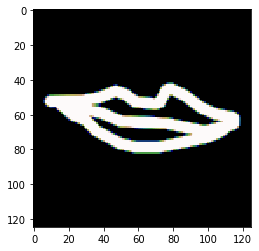

In [9]:
%matplotlib inline

idx = randint(0, len(image))
plt.imshow(np.array(image[idx]).reshape(image_size,image_size), cmap='gist_earth') 
    # print(class_names[int(y[idx].item())])

In [10]:
tmp = []
ct = []
#countries = ['RU','AU','KR','AU','GB','BR','SE','FI','CZ']
#countries = ['US','GB','CA','DE','RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']
countries = ['RU','AU','BR','SE','FI','CZ','IT','KR','SA','PL','FR']
countries_mapping = {'RU':0,'AU':1,'BR':2,'SE':3,'FI':4,'CZ':5,'IT':6,'KR':7,'SA':8,'PL':9,'FR':10}

'''
for c in cls:
    for t in countries:
        x = np.array(image[0]).reshape(image_size,image_size)
        y = np.zeros(x.shape)
        count = 0
        count_total = 0
        for i in range(len(image)):
            if word[i] == c and countrycode[i] == t: #count < 1410 and 
                y += np.array(image[i]).reshape(image_size,image_size)
                count+=1
        y1 = y / count
        ct.append(count)
        tmp.append(y1) 
'''

'\nfor c in cls:\n    for t in countries:\n        x = np.array(image[0]).reshape(image_size,image_size)\n        y = np.zeros(x.shape)\n        count = 0\n        count_total = 0\n        for i in range(len(image)):\n            if word[i] == c and countrycode[i] == t: #count < 1410 and \n                y += np.array(image[i]).reshape(image_size,image_size)\n                count+=1\n        y1 = y / count\n        ct.append(count)\n        tmp.append(y1) \n'

In [11]:
#countries = ['RU','AU','BR','SE','FI','CZ','IT','KR','SA']
countries = ['AU','BR','KR','SA']
#countries_mapping = {'RU':0,'AU':1,'BR':2,'SE':3,'FI':4,'CZ':5,'IT':6,'KR':7,'SA':8,'PL':9,'FR':10}
countries_mapping = {'AU':0,'BR':1,'KR':2, 'SA':3}

In [12]:
raw_data = pd.DataFrame()
raw_data['word'] = word

raw_data['word'] = [class_mapping[x] for x in raw_data['word']]
raw_data['countrycode'] = countrycode
#raw_data['recognized'] = recognized
raw_data['image'] = image

# select the lines which countrycode in countries
raw_data = raw_data.loc[raw_data['countrycode'].isin(countries)]
raw_data['countrycode'] = [countries_mapping[x] for x in raw_data['countrycode']]

In [13]:
raw_data.shape

(49591, 3)

# Model


# Predict countries

In [14]:
# Only keep listed countries: AU,RU,BR,TW,HK,JP,KR,SA
classes = ['face','eye','mouth','nose','ear']
class_mapping = {'face': 0, 'ear': 1,'eye': 2,'mouth': 3,'nose': 4}

In [15]:
sub_data = raw_data[raw_data['word'] == 0]

In [16]:
sub_data

,word,countrycode,image
182492,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182497,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182500,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182509,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182543,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
330808,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330822,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330847,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
330873,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


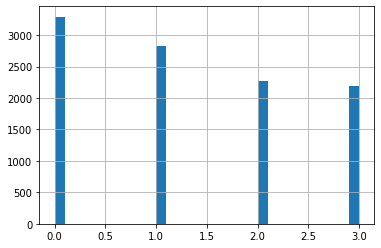

In [17]:
sub_data['countrycode'].hist(bins=30)

### Split data into train and test

In [18]:
# randomize data
from sklearn.utils import shuffle
# data_rnd = shuffle(raw_data[(raw_data['recognized']==1)][['image','countrycode']])

# 你可以在这里调整下是不是选择一个word类别来预测countrycode，现在是有所有的类别


data_rnd = shuffle(sub_data[["image",'countrycode']])
x = train_remake(data_rnd['image'])
y = data_rnd['countrycode']

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=4552,stratify=y)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5, random_state=4552,stratify=y_test)
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
# 没有确定data是不是balanced

In [20]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8454, 15625)
(1057, 15625)
(1057, 15625)
(8454,)
(1057,)
(1057,)


### Reshape and Normalize

In [21]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_val = x_val.reshape(x_val.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(countries))
y_val = keras.utils.to_categorical(y_val, len(countries))
y_test = keras.utils.to_categorical(y_test, len(countries))

In [22]:
x_val.shape

(1057, 125, 125, 1)

### Build model

In [23]:
# Define model
model2 = keras.Sequential()
model2.add(layers.Convolution2D(64, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model2.add(layers.MaxPooling2D(pool_size =(2, 2)))
model2.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model2.add(layers.MaxPooling2D(pool_size =(2, 2)))
#model2.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
#model2.add(layers.MaxPooling2D(pool_size =(2, 2)))
#model2.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
#model2.add(layers.MaxPooling2D(pool_size =(2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(len(countries), activation='softmax')) 
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [27]:
# Train model
import tensorflow
# adam = tf.optimizers.AdamOptimizer(lr=0.01, beta_2 = 0.99999)

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

### Train Model

In [28]:
BATCH_SIZE = 64
model2.fit(x = x_train, y = y_train, \
          validation_data=(x_val, y_val), batch_size = BATCH_SIZE, verbose=1, epochs=10)

Train on 8454 samples, validate on 1057 samples
Epoch 1/10
8454/8454 [==============================] - 92s 11ms/sample - loss: 1.3702 - accuracy: 0.3151 - val_loss: 1.3605 - val_accuracy: 0.3728
Epoch 2/10
8454/8454 [==============================] - 96s 11ms/sample - loss: 1.3006 - accuracy: 0.3927 - val_loss: 1.2861 - val_accuracy: 0.3945
Epoch 3/10
8454/8454 [==============================] - 99s 12ms/sample - loss: 1.2345 - accuracy: 0.4494 - val_loss: 1.2167 - val_accuracy: 0.4655
Epoch 4/10
8454/8454 [==============================] - 97s 11ms/sample - loss: 1.1785 - accuracy: 0.4797 - val_loss: 1.2216 - val_accuracy: 0.4598
Epoch 5/10
8454/8454 [==============================] - 93s 11ms/sample - loss: 1.1239 - accuracy: 0.5160 - val_loss: 1.2111 - val_accuracy: 0.4532
Epoch 6/10
8454/8454 [==============================] - 91s 11ms/sample - loss: 1.0669 - accuracy: 0.5371 - val_loss: 1.1967 - val_accuracy: 0.4740
Epoch 7/10
8454/8454 [==============================] - 92s 11ms

### Testing

In [44]:
loss,accuracy = model2.evaluate(x_test,y_test, verbose=0)
print("accuracy: {:.4f}".format(accuracy))

accuracy: 0.3976


In [ ]:
model_json = model2.to_json()
with open("model_json", "w") as json_file:
    json_file.write(model2.json)

In [ ]:
model2.save_weights("model.h5")